# Read and Join all networks

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-white')
import os

#### OUTPUT #####
fig_path = '/nas2/users/hermuba/fig'

def read_edge(filename, net_name):
    # skip first line header!!
    with open(filename, 'rb') as f:
      
        net = nx.read_edgelist(f, delimiter = ',',nodetype = int, comments = '#', data = [(net_name, float)])
    return(net)



In [2]:
# combine all nets together
base_path = '/home/hermuba/nas2/resist_subnet/'
all_net = {}
for i, net_name in enumerate(['string', 'refseq', 'eskape', 'domain']):
    all_net[net_name] = read_edge(os.path.join(base_path, net_name, 'network.csv'), net_name)
    
    if i == 0:
        combined = all_net[net_name]
    else:
        combined = nx.compose(combined, all_net[net_name])


In [3]:
# integrate gosim as well
gosim_df = pd.read_csv(os.path.join(base_path, 'gosim.csv'), sep = ' ', names = ['gene_id1', 'gene_id2', 'gosim'], skiprows = 1 )
gosim = nx.from_pandas_edgelist(gosim_df, source = 'gene_id1', target = 'gene_id2',  edge_attr='gosim')
combined = nx.compose(combined, gosim)

In [4]:
combined.edges[1, 1672]

{'refseq': 0.7816089826998678,
 'eskape': 0.9320164733109821,
 'domain': 7.141991921130741e-07,
 'gosim': 0.095}

# Convert to dataframe 

In [5]:
edges_prediction = nx.to_pandas_edgelist(combined)
# we only consider those with at least 1 network prediction
edges_prediction = edges_prediction.loc[edges_prediction[['string', 'refseq', 'eskape', 'domain']].count(axis = 1)>0]

In [6]:
edges_prediction.head()

,source,target,domain,gosim,refseq,eskape,string
0,3005,120,7.141992e-07,NaN,1.002549,1.290155,195.0
1,3005,343,3.845063e-07,NaN,1.309979,1.695580,184.0
2,3005,2747,1.905649e-06,0.015,2.209623,1.698512,251.0
3,3005,1483,1.554340e-06,0.052,1.152129,1.548399,206.0
4,3005,3005,NaN,NaN,NaN,NaN,662.0


In [7]:
edges_prediction.shape

(4506396, 7)

In [8]:
edges_prediction.count() # the data is sparse, about half has gosim socre.

source    4506396
target    4506396
domain    2474200
gosim     1026028
refseq    4062675
eskape    4426800
string      48267
dtype: int64

# observe the tradeoff of score and gosim

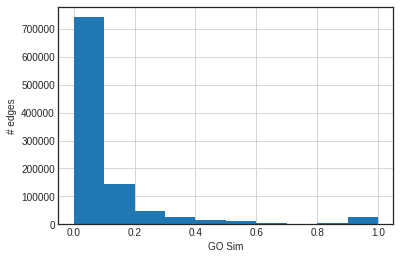

In [9]:
edges_prediction['gosim'].hist()
plt.xlabel('GO Sim')
plt.ylabel('# edges')
plt.savefig(os.path.join(fig_path,'gosim_dist.svg'), format = 'svg', dpi = 300, )

# Plot PPV curve to display that each network has some predictive power

In [10]:
annotation_df = os.path.join(base_path, 'gold_anno.csv')
gold_anno = pd.read_csv(annotation_df)
def PPV(computable, subset = None):
    if subset:
        subcomputable = computable.loc[(computable['target'].isin(subset))|(computable['source'].isin(subset))]
    else:
        subcomputable = computable.copy()
    grouped = subcomputable.groupby(by = ['goldstandard', 'prediction']).count()['target']
    
    try:
        tp = grouped[True, True]
        fp = grouped[False, True]
        PPV = tp/(tp+fp)
        
       
    except KeyError:
        PPV = 0
        
    return PPV

def coverage(computable, all_nodes):
    net = computable.loc[computable['prediction']]
    covered_nodes = set(net['source']).union(net['target']).intersection(all_nodes)
    
    return len(covered_nodes)/len(all_nodes)
    
def PPV_coverage(df, score_col, score_thres, gold_col = 'gosim', gold_thres = 0.6):
    ''' define goldstandard_score > gold_thres as Positive. d'''
    
    # write prediction
    computable = df.loc[(df[score_col].notnull())&(df[gold_col].notnull())]
    computable['prediction'] = df[score_col]>score_thres
    computable['goldstandard'] = df[gold_col]>gold_thres

    
    # total
    ppv = PPV(computable)
    cov = coverage(computable, set(gold_anno['gene_id']))
    
    # core
    core_genes = set(gold_anno.loc[gold_anno['core'], 'gene_id'])
    core_ppv = PPV(computable, subset = core_genes)
    core_cov = coverage(computable, core_genes)
    
    # acc
    acc_genes = set(gold_anno.loc[~gold_anno['core'], 'gene_id'])
    acc_ppv = PPV(computable, subset = acc_genes)
    acc_cov = coverage(computable, acc_genes)
    
    return ppv, core_ppv, acc_ppv, cov, core_cov, acc_cov

def try_thres(df, col, q = 300, interval = 10):
    tradeoff = []

    _, bins = pd.qcut(df[col], q = q, retbins = True, duplicates = 'drop')
    
    for bi in range(0, len(bins), interval):
        
        b = bins[bi]
        scores = PPV_coverage(df, col, b)
        tradeoff.append([b]+list(scores))
    return pd.DataFrame(tradeoff, columns = ['{}_score'.format(col), 'ppv', 'core_ppv', 'acc_ppv', 'cov', 'core_cov', 'acc_cov'])
    

In [11]:
import numpy as np
for net in ['string', 'refseq', 'eskape', 'domain']:
    # predicting those with gosim > 0.6
    d = try_thres(edges_prediction, net)
    d.to_csv(os.path.join(base_path, 'preformance', '{}.ppv_cov.csv'.format(net)))

/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
def lls(all_df, score, gold_col = 'gosim', gold_thres = 0.3, bins = 300):
    '''
    lls calculator for domain-weighted net, using qcut, bin = 250 (optimized)
    input:
    all_df: joined dataframe with goldstandard and "score"
    score: the name of "score"; in this case: "weighted_mutual"

    '''
    #drop = ['gene_one', 'gene_two', 'goldstandard']
    #score = list(set(all_df.columns) - set(drop))[0] # context has two kinds of scores

    all_df = all_df.loc[all_df[score].notnull()]
    all_df['cut_mutual'] = pd.qcut(all_df[score],  bins, duplicates = 'drop')
    all_df['goldstandard'] = all_df[gold_col]>gold_thres


    grouped = all_df.groupby(by = ['goldstandard', 'cut_mutual']).count()['target']
    grouped = grouped.fillna(0)
    
     # pseudocount
    L_E = grouped[1] + 1
    not_L_E = grouped[0] + 1
    L = grouped[1].sum()+1
    not_L = grouped[0].sum()+1
    
    
    lls_score = np.log((L_E/not_L_E)/(L/not_L))


    return lls_score

In [13]:
def fitting_LLS(all_chunk, bins = 100, lls_function = lls,  score = 'mutual_info'):

    
    lls_score = lls(all_chunk, score, bins = bins)

    # do OLD METHOD: linear regression when LLS > threshold; try different inflection point
    linear = {}
    linear_mse = {}
    for lls_thres in [0,1,2,3]:
        try:
            true_thres, slope, intercept = lls_regress_thres(lls_score, lls_thres = lls_thres)
            linear_lls = map_lls(lls_score, true_thres, slope, intercept)
            linear[lls_thres] = linear_lls
    
            # calculate MSE
            mse = np.sum((linear_lls.values - lls_score.values)**2) # we only care about data points with good signal
            linear_mse[lls_thres] = mse
        except:
            print('no bin has LLS greater than {}'.format(lls_thres))


    # new method, exponential
    subset = lls_score.copy()

    # exp can't have <=0 zero values
    
    #smallest_nonneg = subset[subset>0].min()
    #subset.loc[subset<0] = smallest_nonneg
    x = np.array(range(len(subset)))
    sub_x = x[np.where(subset.values>0)]

    subset = subset.loc[subset>0]
    y = subset.values
    

    # Try different params
    expo_curves = {}
    expo_mse = {}
    
    from math import ceil
    for top_bins in range(5, 50, 5):
        expo_param = np.polyfit(sub_x[-top_bins:], np.log(y[-top_bins:]), 1) #y = Ae*bx
        fitted = np.exp(expo_param[1]) * np.exp(expo_param[0]*np.array(x))
        expo_curves[top_bins]=fitted
    
        mse = np.sum((fitted - lls_score.values)**2)
        expo_mse[top_bins] = mse
    return lls_score, linear, linear_mse, expo_curves, expo_mse


/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


no bin has LLS greater than 0
no bin has LLS greater than 1
no bin has LLS greater than 2
no bin has LLS greater than 3
no bin has LLS greater than 0
no bin has LLS greater than 1
no bin has LLS greater than 2
no bin has LLS greater than 3
no bin has LLS greater than 0
no bin has LLS greater than 1
no bin has LLS greater than 2
no bin has LLS greater than 3
no bin has LLS greater than 0
no bin has LLS greater than 1
no bin has LLS greater than 2
no bin has LLS greater than 3


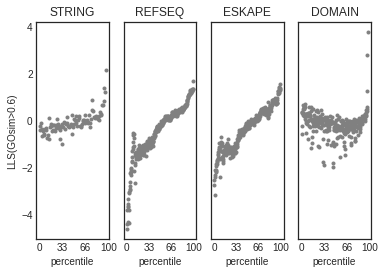

In [14]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1,4, figsize = (6,4), sharey = True)
best_fit_for_net = {}
for net, ax in zip(['string', 'refseq', 'eskape', 'domain'], axes):
    if net == 'string': 
        bins = 100
    else:
        bins = 300
    lls_score, linear, linear_mse, expo_curves, expo_mse = fitting_LLS(edges_prediction, score = net, bins = bins)
    
    #plt.figure()
    ax.plot(lls_score, '.', label = 'original data', color = 'grey')
    
    ## find best fit
    min_mse = min(list(expo_mse.values()))
    
    # best_fit
    best_fit = [k for k in expo_mse.keys() if expo_mse[k] == min_mse][0]
    
    #plt.plot(expo_curves[best_fit], label = '{} bins, MSE={}'.format(best_fit, expo_mse[best_fit]))
    
    #for t in linear.keys():
    #    plt.plot(linear[t], label = 'LLS_thres={}, MSE = {}'.format(t, linear_mse[t]))
    
    # save the best lls fitting
    best_fit_for_net[net] = pd.Series(expo_curves[best_fit], index = lls_score.index)
    #plt.text(0.5, 1, '{0:e} *exp({1:2f}  x)'.format(np.exp(new[1]), np.exp(new[0])))
    ax.set_xlabel('percentile')
    ax.set_title(net.upper())
    ax.set_xticks(range(0,bins+1, int(bins/3)))
    ax.set_xticklabels([0,33,66,100])
axes[0].set_ylabel('LLS(GOsim>0.6)')
    

    #plt.legend(bbox_to_anchor = (1.5, 1))
    #plt.title('Curve Fitting for {}'.format(net.upper()))
    #edges_prediction['{}_lls'.format(net)] = edges_prediction[net].map(lls_score)
f.savefig(os.path.join(fig_path,'LLS_score.svg'), format = 'svg', dpi = 300, )

In [15]:
import numpy as np
def bayesian_integration(lls_scores, D = 1):
    ''' Bayesian Integration to integrate many networks
    D is a constant, please see the original paper'''
    sorted_lls = np.sort(np.array(lls_scores))[::-1]  #descending
    rank = D*np.arange(len(sorted_lls))+1 # rank 1,2,3,4
    
    ans = np.sum(sorted_lls/rank)
    
    
    return ans


In [16]:
# map LLS to the edge
for net in best_fit_for_net.keys():
    edges_prediction[net+'_lls'] = edges_prediction[net].map(best_fit_for_net[net])

In [17]:
edges_prediction.head()

,source,target,domain,gosim,refseq,eskape,string,string_lls,refseq_lls,eskape_lls,domain_lls
0,3005,120,7.141992e-07,NaN,1.002549,1.290155,195.0,1.669792e-07,1.058576,1.044754,5.500844e-14
1,3005,343,3.845063e-07,NaN,1.309979,1.695580,184.0,2.416068e-08,1.293912,1.506386,2.140233e-23
2,3005,2747,1.905649e-06,0.015,2.209623,1.698512,251.0,7.265381e-05,1.581566,1.506386,7.821495e-04
3,3005,1483,1.554340e-06,0.052,1.152129,1.548399,206.0,8.755470e-07,1.170343,1.345975,4.519975e-05
4,3005,3005,NaN,NaN,NaN,NaN,662.0,3.795596e-01,0.037611,0.022091,1.607059e-36


In [18]:
for t in edges_prediction.loc[:5, ['string_lls', 'refseq_lls', 'eskape_lls', 'domain_lls']].values.tolist():
    print(t)

[1.6697920971928102e-07, 1.0585757743635484, 1.0447542655053537, 5.5008439179314654e-14]
[2.4160679159532922e-08, 1.2939115604355167, 1.5063857125556808, 2.140233235202871e-23]
[7.265380618480717e-05, 1.5815656911620366, 1.5063857125556808, 0.0007821494939851707]
[8.755470396306658e-07, 1.1703432966638359, 1.3459753310526783, 4.5199752390965915e-05]
[0.3795595864362858, 0.03761062274539714, 0.02209125555895157, 1.6070587228201715e-36]
[1.3907106398498602e-08, 1.2000824985941116, 1.236980303743552, 3.954084132200664e-25]


In [19]:

lls_cols = ['string_lls', 'refseq_lls', 'eskape_lls', 'domain_lls']
# select positive edges that has some lls at least,
positive_edge = edges_prediction.loc[edges_prediction[lls_cols].sum(axis = 1)>1]

In [20]:
positive_edge['baye_score'] = positive_edge[lls_cols].apply(bayesian_integration, axis = 1)

/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:

edges_prediction.to_csv(os.path.join('/home/hermuba/nas2/integrate_net/baye.csv'))

positive_edge.to_csv(os.path.join('/home/hermuba/nas2/integrate_net/baye_pos.csv'))

In [22]:

net = 'baye_score'
d = try_thres(positive_edge, net)
d.to_csv(os.path.join(base_path, 'preformance', '{}.ppv_cov.csv'.format(net)))

/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:xlabel='baye_score', ylabel='gosim'>

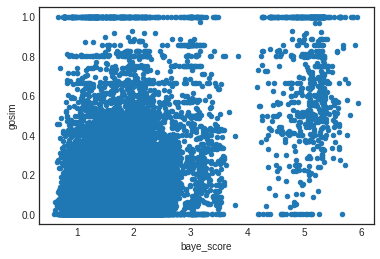

In [23]:
positive_edge.plot.scatter(x = 'baye_score', y = 'gosim')

In [24]:
positive_edge.loc[positive_edge['baye_score']>1].to_csv('/home/hermuba/nas2/integrate_net/baye_pos_greater_1.csv')

In [25]:
best_fit_for_net['domain']>4

cut_mutual
(4.162906958300002e-13, 7.8051831076e-10]    False
(7.8051831076e-10, 1.26564416239e-09]        False
(1.26564416239e-09, 1.80773472797e-09]       False
(1.80773472797e-09, 2.33661580926e-09]       False
(2.33661580926e-09, 2.80932694057e-09]       False
                                             ...  
(3.90973434496e-06, 4.56558162909e-06]       False
(4.56558162909e-06, 6.01006792468e-06]       False
(6.01006792468e-06, 1.32273266585e-05]       False
(1.32273266585e-05, 8.37713456242e-05]       False
(8.37713456242e-05, 0.0223022210078]          True
Length: 294, dtype: bool

# core genes

In [26]:
core_ids = gold_anno.loc[gold_anno['core'], 'gene_id']
acc_ids = gold_anno.loc[~gold_anno['core'], 'gene_id']

In [27]:
core_core_itxn = edges_prediction.loc[(edges_prediction['target'].isin(core_ids)) & (edges_prediction['source'].isin(core_ids))]
acc_acc_itxn = edges_prediction.loc[(edges_prediction['target'].isin(acc_ids)) & (edges_prediction['source'].isin(acc_ids))]

In [28]:
def plot_cdf(values, ax, name):
    x = np.sort(values)
    y = np.linspace(0,1,len(x))
    ax.plot(x,y, label = name)

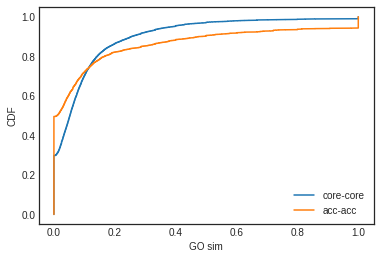

In [29]:
f, ax = plt.subplots()
plot_cdf(core_core_itxn['gosim'].dropna(), ax = ax, name = 'core-core')
plot_cdf(acc_acc_itxn['gosim'].dropna(), ax = ax, name = 'acc-acc')
plt.legend()
plt.xlabel('GO sim')
plt.ylabel('CDF')
plt.savefig(os.path.join(fig_path,'gosim_dist_acc_core.svg'), format = 'svg', dpi = 300, )